In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Define the neural network model with sigmoid activation
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64,64)
        self.output_layer = nn.Linear(64, 1)
        self.activation = torch.sigmoid

    def forward(self, x):
        x = self.activation(self.hidden_layer1(x))
        x = self.activation(self.hidden_layer2(x))
        return self.output_layer(x)

In [3]:
# Training the model
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 5000

In [4]:
# Define the Laplace equation: -Δu = 0
def pde_loss(model, points):
    points.requires_grad_(True)
    u = model(points)
    grads = torch.autograd.grad(
        u, points, grad_outputs=torch.ones_like(u), create_graph=True
    )[0]
    u_x, u_y = grads[:, 0:1], grads[:, 1:2]
    u_xx = torch.autograd.grad(u_x, points, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(u_y, points, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]
    return ((u_xx + u_yy) ** 2).mean()

In [5]:
# Define boundary loss
def boundary_loss(model, boundary_points, boundary_values):
    u_pred = model(boundary_points)
    return ((u_pred - boundary_values) ** 2).mean()

In [6]:
import numpy as np
import torch

def init_circle(nx: int, ny: int, boundaries: list, eps: int = 0):
    """
    Initialize the solution matrix and generate boundary and collocation points.
    
    Args:
        nx: number of grid points in x direction
        ny: number of grid points in y direction
        boundaries: list of boundary values [top, bottom]
        eps: tolerance for boundary approximation
    
    Returns:
        boundary_points: torch tensor of boundary points
        boundary_values: torch tensor of boundary values
        collocation_points: torch tensor of points inside the circle
    """
    center = (nx // 2, ny // 2)
    radius = nx // 2

    # Initialize solution and mask
    solution = np.zeros((ny, nx))
    mask = np.ones((ny, nx))

    boundary_points = []
    boundary_values = []
    collocation_points = []

    for i in range(ny):
        for j in range(nx):
            r = (i - center[1]) ** 2 + (j - center[0]) ** 2
            if r > radius**2:  # Outside the circle
                solution[i, j] = -100
                mask[i, j] = 0
            elif radius**2 - eps <= r <= radius**2 + eps:  # On the boundary
                x = (j - center[0]) / radius  # Normalize to [-1, 1]
                y = (i - center[1]) / radius  # Normalize to [-1, 1]
                boundary_points.append([x, y])

                if y > 0:  # Top half
                    boundary_values.append(boundaries[0])
                else:  # Bottom half
                    boundary_values.append(boundaries[1])
                mask[i, j] = 0
            else:  # Inside the circle
                x = (j - center[0]) / radius  # Normalize to [-1, 1]
                y = (i - center[1]) / radius  # Normalize to [-1, 1]
                collocation_points.append([x, y])

    # Convert to tensors
    boundary_points = torch.tensor(boundary_points, dtype=torch.float32)
    boundary_values = torch.tensor(boundary_values, dtype=torch.float32).unsqueeze(1)
    collocation_points = torch.tensor(collocation_points, dtype=torch.float32)

    return boundary_points, boundary_values, collocation_points


In [7]:
nx, ny = 100, 100
boundaries = [100.0, 50.0]  # Top and bottom boundary values
eps = 2

boundary_points, boundary_values, collocation_points = init_circle(nx, ny, boundaries, eps)


In [8]:
# Training loop
losses = []
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    loss_pde = pde_loss(model, collocation_points)
    u_pred_boundary = model(boundary_points)
    loss_bc = torch.mean((u_pred_boundary - boundary_values) ** 2)
        # Balance the loss terms
    loss_pde_weight = 1.0  # Weight for PDE loss
    loss_bc_weight = 10.0  # Higher weight for boundary condition loss

    loss =  loss_pde + loss_bc_weight * loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

  0%|          | 4/5000 [00:00<05:36, 14.86it/s]

Epoch 0, Loss: 59131.15234375


 10%|█         | 505/5000 [00:17<04:16, 17.54it/s]

Epoch 500, Loss: 420.2598876953125


 20%|██        | 1004/5000 [00:38<02:21, 28.23it/s]

Epoch 1000, Loss: 90.0773696899414


 30%|███       | 1506/5000 [00:57<01:51, 31.25it/s]

Epoch 1500, Loss: 31.923873901367188


 40%|████      | 2007/5000 [01:19<01:42, 29.23it/s]

Epoch 2000, Loss: 40.27507781982422


 50%|█████     | 2503/5000 [01:40<01:40, 24.79it/s]

Epoch 2500, Loss: 10.268826484680176


 60%|██████    | 3005/5000 [02:01<01:22, 24.15it/s]

Epoch 3000, Loss: 9.102313995361328


 70%|███████   | 3506/5000 [02:22<00:55, 26.84it/s]

Epoch 3500, Loss: 6.363125324249268


 80%|████████  | 4005/5000 [02:41<00:37, 26.21it/s]

Epoch 4000, Loss: 10.296820640563965


 90%|█████████ | 4504/5000 [03:01<00:20, 24.20it/s]

Epoch 4500, Loss: 7.390105724334717


100%|██████████| 5000/5000 [03:23<00:00, 24.60it/s]


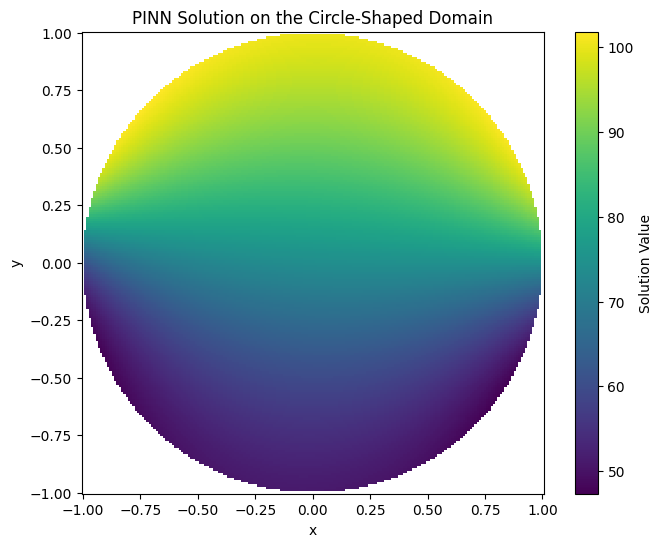

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

with torch.no_grad():
    # Generate grid for plotting
    x = np.linspace(-1, 1, 200)
    y = np.linspace(-1, 1, 200)
    X, Y = np.meshgrid(x, y)
    grid_points = np.column_stack([X.ravel(), Y.ravel()])

    # Mask out points outside the unit circle (x^2 + y^2 <= 1)
    mask = X**2 + Y**2 <= 1.0
    # np.array([Point(p).distance(Point(0, 0)) <= 1.0 for p in grid_points])

    # Convert grid points to tensor for model prediction
    XY = torch.tensor(grid_points, dtype=torch.float32)

    # Predict solution on the grid
    with torch.no_grad():
        u_pred = model(XY).detach().numpy().reshape(X.shape)

    # Reshape the prediction and mask to match the grid shape
    u_pred_masked = np.full(u_pred.shape, np.nan)
    u_pred_masked[mask] = u_pred[mask]
# u_pred_masked = u_pred_masked.reshape(X.shape)

# Plot in 2D heatmap
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, u_pred_masked, cmap="viridis", shading="auto")
plt.colorbar(label="Solution Value")
plt.title("PINN Solution on the Circle-Shaped Domain")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
# plt.grid(True)
plt.show()


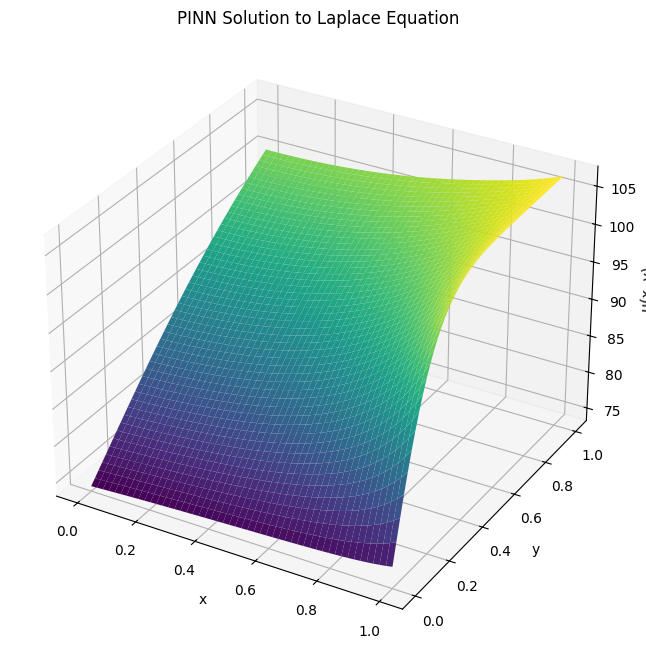

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Generate grid for plotting
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)
XY = torch.tensor(np.column_stack([X.ravel(), Y.ravel()]), dtype=torch.float32)

# Predict solution on the grid
u_pred = model(XY).detach().numpy().reshape(X.shape)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u_pred, cmap="viridis", edgecolor="none")
ax.set_title("PINN Solution to Laplace Equation")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x, y)")
plt.show()

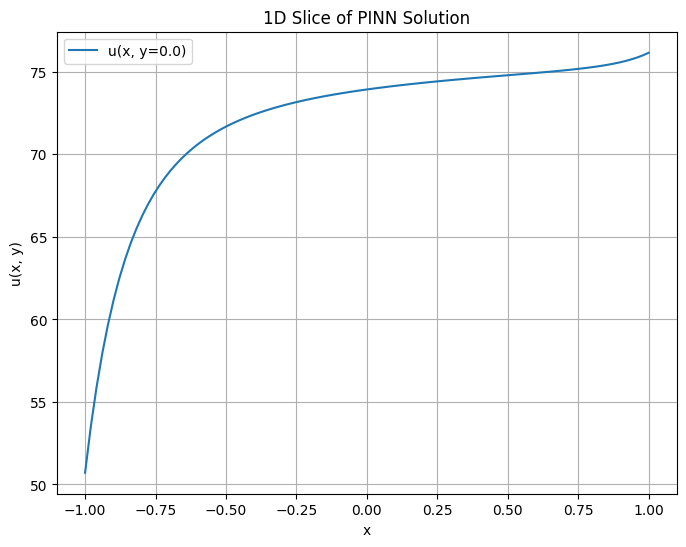

In [12]:
# Generate 1D data along a fixed y value (e.g., y = 0.5)
# Extract a 1D slice for y = 0
fixed_y = 0.0
x_values = np.linspace(-1, 1, 100)  # Cover the full width of the circle
points_slice = torch.tensor(np.column_stack([x_values, np.full_like(x_values, fixed_y)]), dtype=torch.float32)

# Predict the solution for the slice
with torch.no_grad():
    u_slice = model(points_slice).cpu().numpy()

# Plot the 1D solution
plt.figure(figsize=(8, 6))
plt.plot(x_values, u_slice, label=f"u(x, y={fixed_y})")
plt.title("1D Slice of PINN Solution")
plt.xlabel("x")
plt.ylabel("u(x, y)")
plt.legend()
plt.grid(True)
plt.show()


Epoch 0, Loss: 5912.83154296875
Epoch 500, Loss: 2285.663818359375
Epoch 1000, Loss: 949.101318359375
Epoch 1500, Loss: 640.4321899414062
Epoch 2000, Loss: 366.50762939453125
Epoch 2500, Loss: 168.68894958496094
Epoch 3000, Loss: 75.06312561035156
Epoch 3500, Loss: 37.60116958618164
Epoch 4000, Loss: 24.962621688842773
Epoch 4500, Loss: 17.489036560058594


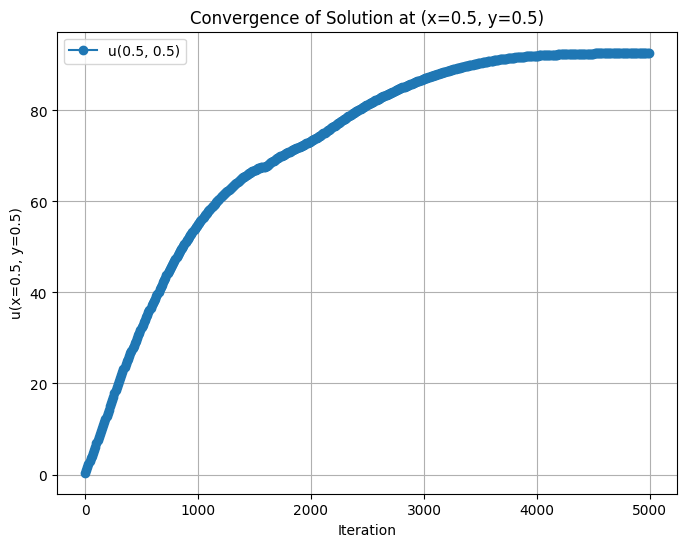

In [13]:
# Fixed spatial point for monitoring
fixed_point = torch.tensor([[0.5, 0.5]], dtype=torch.float32)

# Array to store predicted values at each iteration
convergence_values = []

# Training loop with monitoring
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5000

for epoch in range(epochs):
    optimizer.zero_grad()
    loss_pde = pde_loss(model, collocation_points)
    loss_bc = boundary_loss(model, boundary_points, boundary_values)
    loss = loss_pde + loss_bc
    loss.backward()
    optimizer.step()

    # Store the prediction at the fixed point
    if epoch % 10 == 0:  # Record every 10 epochs to reduce noise
        u_fixed = model(fixed_point).detach().cpu().item()
        convergence_values.append(u_fixed)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Plot the convergence
iterations = np.arange(0, len(convergence_values)) * 10  # Iterations corresponding to recorded values
plt.figure(figsize=(8, 6))
plt.plot(iterations, convergence_values, label=f"u(0.5, 0.5)", marker="o")
plt.title("Convergence of Solution at (x=0.5, y=0.5)")
plt.xlabel("Iteration")
plt.ylabel("u(x=0.5, y=0.5)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), "PINN.pt")

In [ ]:
model.load_state_dict(torch.load('PINN.pt'), strict=False)